In [1]:
#Processing the Ganymed data


import astropy, numpy
print(astropy.__version__)
print(numpy.__version__)

6.1.4
2.1.1


In [2]:
#setup and imports

import sys
import os

# Set the ISISROOT environment variable
os.environ['ISISROOT'] = '/Users/zouxd/Application/isis3dev/isis3comets/isis'#/isis3comets/isis'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['ISISROOT'], 'bin')

sys.path.append('/Users/zouxd/Documents/2-Projects/2024-YORPD/ALMA/')  # 添加路径到 sys.path
sys.path.append('/Users/zouxd/Documents/--Tools--/addings/mpfit/')

from astropy.io import ascii
from mpfit import mpfit
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import jylipy as jp
import spiceypy as spice

/Users/zouxd/miniconda3/lib/python3.12/site-packages/pyds9.py:94: UserWarning: Can't locate the X11 DS9 executable in your PATH or the Aqua SAOImage DS9 app in /Applications, $HOME or $HOME/Applications. Please configure your PATH or make SAOImage DS9 available in a known location.
  warnings.warn(ds9_warning)
/Users/zouxd/miniconda3/lib/python3.12/site-packages/pysis/env.py:33: RuntimeWarning: Could not find isis. Is `ISISROOT` set?
  warnings.warn('Could not find isis. Is `ISISROOT` set?', RuntimeWarning)


## Preprocessing of KRC Model

The temperature models are provided by T.N. Titus using KRC.  The models are in a multidimentional array, with 48 (Local Time) x 19 (Latitudes) x 100 (depths) x 7 (thermal inertia) x 3 (emissivity).  Parameters listed below, based on Titus's email on 2023-09-11.
* Local time starts at midnight in increments of 0.5 hours.
* Latitudes start at -90 and proceed to +90 in 10 degree increments.
* Thermal Inertia starts at 10, 20, 40, 80, 160, 320, 640 tiu.
* Emissivity 0.5, 0.7, 0.9.
* Depths are in fractions of a skin depth specified in FITS extensions.

The mapping from temperature model to Didymos's and Dimorphos's simulated images using triangulate plate shape model is performed with IDL function 'tpm_sph2plt.pro'.  This function requires temperature model to be in a 3D array of (N, D, M) in N local solar times starting from local noon, D depths, and M latitudes.  Therefore, the original model needs to be processed to format to comply with this format.

In this step, the raw temperature models are processed and broken into individual temperature files that each corresponding to one combination of thermal inertia and emissivity.  Each temperature profile will have the format complying with the requirement by 'tpm_sph2plt.pro'.

The output are saved in file names `'KRC/[didy|dimo]/tref_gamma{:d}_emis{:.1f}.fits'.format(ti, emis)`

In [6]:
tmp = fits.open(infile) 
tmp.info()

Filename: KRC/Ganymed_krc_temps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (48, 19, 7, 3, 100)   float32   
  1                1 ImageHDU         6   (48,)   float32   
  2                1 ImageHDU         7   (1, 19)   float32   
  3                1 ImageHDU         8   (1, 1, 7)   float32   
  4                1 ImageHDU         9   (1, 1, 1, 3)   float32   
  5                1 ImageHDU        10   (1, 1, 7, 1, 100)   float64   


In [7]:
# preprocess temperature model
# reshapes the 5D KRC temperature array into 3D slices per TI/emissivity combo and saves them in a format
# 5D KRC to 3D inputs for IDL 5D：Time × Lat × Depth × TI × Emis


from astropy.io import fits
from ALMACeres import tiu
u.add_enabled_units(tiu)

#obj = 'Ganymed'
obj = 'Ganymed'


if obj == 'Ganymed':
    infile = 'KRC/Ganymed_krc_temps.fits'
    outdir = 'KRC/Ganymed/'
    period_rot = 10.31284 * u.hour



# parameters from Titus:
period_orb = 4.35 * u.year    # orbital period   (from Tim:period_orb = 1589.339 (Julian Days))
rho = 11190 * u.Unit('kg/m3')    # density (from Tim/: Density  11190 kg/m3)
c = 750 * u.Unit('J/(K kg)')   # specific heat ( From Tim: Specific Heat 750)

# thermal skin depth
askin = np.sqrt(period_orb / np.pi) * tiu / rho * c

with fits.open(infile) as f_:
    temp = f_[0].data * u.K
    lst = f_[1].data * u.hour  #Local Solar Time
    lat = np.squeeze(f_[2].data) * u.deg 
    ti = np.squeeze(f_[3].data) * tiu # Thermal Inertia
    emis = np.squeeze(f_[4].data)   #emissivity
    dep = np.squeeze(f_[5].data) * u.m  #depth (倍数)

# make the format in compliance with the requirement by IDL routine 'tpm_sph2plt.pro'
temp = np.moveaxis(temp, 0, 3)  # move time axis to the first 
s = np.where(lst == 12 * u.hour)[0] # 对齐时间到正午开始 for IDL
lst = np.roll(lst, -s)
if lst[0] != 12 * u.hour:
    raise ValueError('something went wrong with shifting arrays')
temp = np.roll(temp, -s, axis=-1)

for i, e in enumerate(emis):
    for j, t in enumerate(ti):
        # slice the temperature model
        tref = temp[i, j]

        # save reference temperature model
        hdu0 = fits.PrimaryHDU(tref.to_value('K'))
        hdu0.header['bunit'] = 'K'
        hdu0.header['ti'] = t.to_value('tiu'), 'thermal inertia [tiu]'
        hdu0.header['emiss'] = e, 'emissivity'
        hdu0.header['rho'] = rho.to_value('kg/m3'), 'density [kg/m**3]'
        hdu0.header['c'] = c.to_value('J/(K kg)'), 'specific heat [J/kg]'
        hdu0.header['p_orb'] = period_orb.to_value('year'), 'orbital period [year]'
        hdu0.header['p_rot'] = period_rot.to_value('hour'), 'rotational period [hour]'
        hdu0.header['a_skin'] = (np.sqrt(period_orb / np.pi) * t / (rho * c)).to_value('m'), 'annual thermal skin depth [m]'
        hdu0.header['d_skin'] = (np.sqrt(period_rot / np.pi) * t / (rho * c)).to_value('m'), 'diurnal thermal skin depth [m]'
        hdu1 = fits.ImageHDU(lst.to_value('hour'), name='lst')
        hdu1.header['bunit'] = 'hour'
        hdu2 = fits.ImageHDU(dep[:, j].to_value('m'), name='depth')
        hdu2.header['bunit'] = 'm'
        hdu3 = fits.ImageHDU(lat.to_value('deg'), name='lat')
        hdu3.header['bunit'] = 'deg'
        outfile = outdir + 'tref_gamma{:.0f}_emis{:.2f}.fits'.format(t.value, e)
        fits.HDUList([hdu0, hdu1, hdu2, hdu3]).writeto(outfile, overwrite=True)


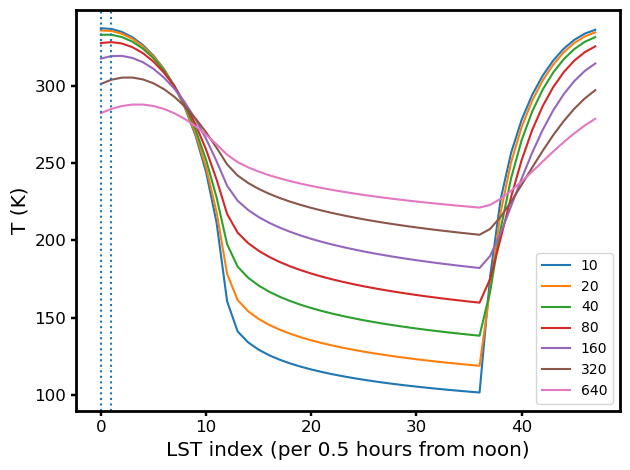

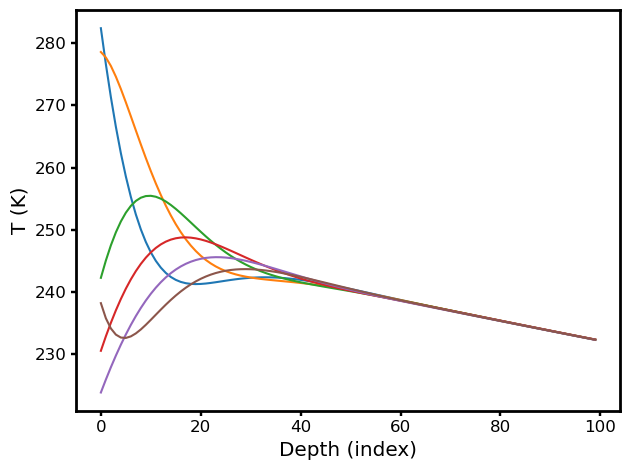

In [8]:
#Load temperature files for different thermal inertia (TI)
ti = [10, 20, 40, 80, 160, 320, 640] # list of TI values
tref = [fits.open(f) for f in ['KRC/Ganymed/tref_gamma{}_emis0.90.fits'.format(t) for t in ti]]

#Plot 1 — Surface temperature (vs LST index) for each TI
plt.figure()
for t in tref:
    plt.plot(t[0].data[9, 0]) # latitude index 9 (near equator), depth = 0 (surface)
plt.axvline(0, linestyle=':')
plt.axvline(1, linestyle=':')
jp.pplot(xlabel='LST index (per 0.5 hours from noon)', ylabel='T (K)', skipline=True)
plt.legend(ti)

#Plot 2 — Temperature vs depth at various times
plt.figure()
for i in range(0, 48, 8):
    plt.plot(t[0].data[9, :, i])
jp.pplot(xlabel='Depth (index)', ylabel='T (K)', skipline=True)

#Plot 1: Compares how surface temperature varies by TI through a diurnal cycle.

#Plot 2: Shows how temperature propagates into the subsurface at different times.



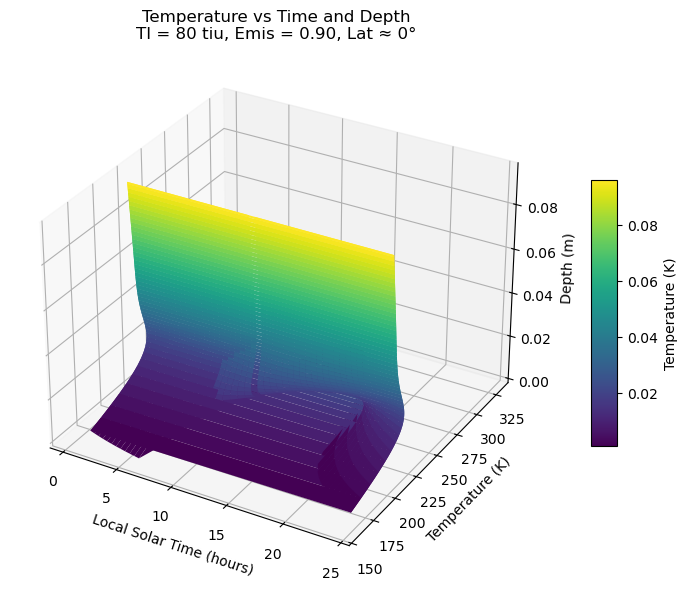

In [9]:
# === Load the temperature model for one thermal inertia & emissivity combination ===
#depth are different for diff TI

filename = 'KRC/Ganymed/tref_gamma80_emis0.90.fits'
hdul = fits.open(filename)

# Main temperature data (Primary HDU), shape: (latitude, depth, time)
temp = hdul[0].data

# Read supporting axes from Image HDUs
lst = hdul['lst'].data        # Local solar times (48 points, in hours)
depth = hdul['depth'].data    # Depths (100 points, in meters)
lat = hdul['lat'].data        # Latitudes (19 points, in degrees)

# === Select a latitude index to visualize (e.g., index 9 ≈ equator) ===
ilat = 9
z = temp[ilat, :, :].T  # Slice and transpose to shape (time, depth)

# === Create a meshgrid for plotting: time vs. depth ===
# The meshgrid must match the shape of z: (48 time steps × 100 depth points)
LST, DEPTH = np.meshgrid(lst, depth, indexing='ij')

# === 3D Surface Plot ===
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with temperature as the Z-axis
surf = ax.plot_surface(LST, z, DEPTH, cmap='viridis')

# Label axes and title
# LST, DEPTH, z

ax.set_xlabel('Local Solar Time (hours)')
ax.set_ylabel('Temperature (K)')
ax.set_zlabel('Depth (m)')
ax.set_title('Temperature vs Time and Depth\nTI = 80 tiu, Emis = 0.90, Lat ≈ {:.0f}°'.format(lat[ilat]))

# Add colorbar for temperature values
fig.colorbar(surf, shrink=0.5, aspect=10, label='Temperature (K)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#switch depth to z
#also plot a 2d of time x vs depth y

[0.         0.00097367 0.00194735 0.00292102 0.0038947  0.00486837
 0.00584204 0.00681572 0.00778939 0.00876307 0.00973674 0.01071041
 0.01168409 0.01265776 0.01363144 0.01460511 0.01557879 0.01655246
 0.01752613 0.01849981 0.01947348 0.02044716 0.02142083 0.0223945
 0.02336818 0.02434185 0.02531553 0.0262892  0.02726287 0.02823655
 0.02921022 0.0301839  0.03115757 0.03213124 0.03310492 0.03407859
 0.03505227 0.03602594 0.03699961 0.03797329 0.03894696 0.03992064
 0.04089431 0.04186798 0.04284166 0.04381533 0.04478901 0.04576268
 0.04673636 0.04771003 0.0486837  0.04965738 0.05063105 0.05160473
 0.0525784  0.05355207 0.05452575 0.05549942 0.0564731  0.05744677
 0.05842044 0.05939412 0.06036779 0.06134147 0.06231514 0.06328881
 0.06426249 0.06523616 0.06620984 0.06718351 0.06815718 0.06913086
 0.07010453 0.07107821 0.07205188 0.07302555 0.07399923 0.0749729
 0.07594658 0.07692025 0.07789393 0.0788676  0.07984127 0.08081495
 0.08178862 0.0827623  0.08373597 0.08470964 0.08568332 0.086656

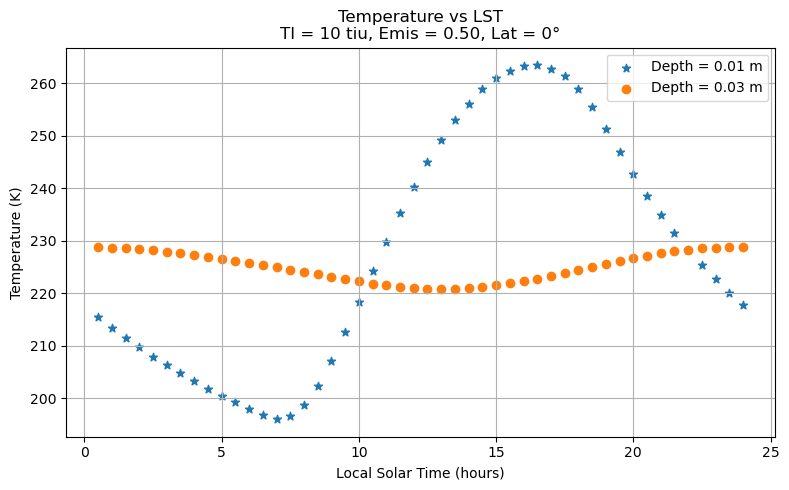

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# === Load the temperature model ===
filename = 'KRC/Ganymed/tref_gamma80_emis0.90.fits'
hdul = fits.open(filename)
temp = hdul[0].data
lst = hdul['lst'].data
depth = hdul['depth'].data
lat = hdul['lat'].data
print(depth)
# === Select latitude index ===
ilat = 9  # Near equator

# === Depths to plot ===
depths_to_plot = [0.01, 0.03]
markers = ['*', 'o']
colors = ['tab:blue', 'tab:orange']

# === Plot LST vs Temperature for both depths ===
plt.figure(figsize=(8, 5))

for d, m, c in zip(depths_to_plot, markers, colors):
    idepth = np.argmin(np.abs(depth - d))
    print(idepth)
    temperature = temp[ilat, idepth, :]
    plt.scatter(lst, temperature, marker=m, color=c, label='Depth = {:.2f} m'.format(depth[idepth]))

plt.xlabel('Local Solar Time (hours)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs LST\nTI = 10 tiu, Emis = 0.50, Lat = {:.0f}°'.format(lat[ilat]))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
print(lat)

[-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.
  50.  60.  70.  80.  90.]


In [12]:
t = fits.open('KRC/Ganymed/tref_gamma40_emis0.90.fits')
t.info()

Filename: KRC/Ganymed/tref_gamma40_emis0.90.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (48, 100, 19)   float32   
  1  LST           1 ImageHDU         8   (48,)   float32   
  2  DEPTH         1 ImageHDU         8   (100,)   float64   
  3  LAT           1 ImageHDU         8   (19,)   float32   


In [13]:
t = fits.open('KRC/Ganymed/tref_gamma40_emis0.90.fits')
t.info()

Filename: KRC/Ganymed/tref_gamma40_emis0.90.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (48, 100, 19)   float32   
  1  LST           1 ImageHDU         8   (48,)   float32   
  2  DEPTH         1 ImageHDU         8   (100,)   float64   
  3  LAT           1 ImageHDU         8   (19,)   float32   


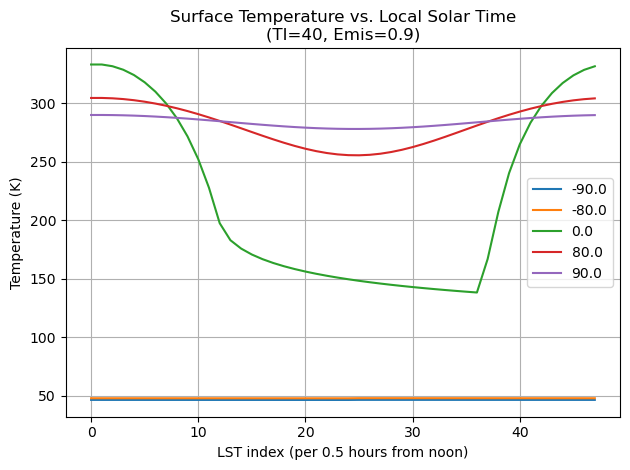

In [14]:

# plots surface temperature curves vs. time (LST index) for multiple latitudes using one specific KRC model (TI = 40, emis = 0.90).
t = fits.open('KRC/Ganymed/tref_gamma40_emis0.90.fits')
lats = [0, 1, 9, 17, 18] # latitude indices: from -90° to +90°

plt.figure()
for lat in lats:
    plt.plot(t[0].data[lat, 0, :]) # temp[lat, depth=0, time]
#jp.pplot(xlabel='LST index (per 0.5 hours from noon)', ylabel='T (K)', skipline=True)
plt.legend(t['lat'].data[lats]) # show latitude values in legend
plt.xlabel('LST index (per 0.5 hours from noon)')
plt.ylabel('Temperature (K)')
plt.title('Surface Temperature vs. Local Solar Time\n(TI=40, Emis=0.9)')
plt.grid(True)
plt.tight_layout()


## Calculate Geometry at Thermal Observations

Thermal observations were taken at 

Target UT Date UT Time Telescopea Wavelength t rhg ∆h αi
Ganymed 9/18/2024 18:10 - 18:35 IRAM 2.06 / 2.30 mm
9/19/2024 15:10 - 17:13 IRAM 3.33 / 3.99 mm
10/14/2024 04:00 - 12:25 SMA 1.3 mm
10/16/2024 04:10 - 12:15 SMA 1.3 mm
10/23/2024 04:34 - 07:59 VLA 30, 20, 9 mm
10/23/2024 04:00 - 08:00 VLA 30, 20, 9 mm

# === Specify observation time (UTC) ===
# Format: 'YYYY-MM-DDTHH:MM'
ut = '2024-09-18T18:10'  # You can update this to other times: 9/19T15:10, 10/14T04:00, etc.

# === Load SPICE kernels ===
# This .tm file should list required kernels: SPK, PCK, LSK, etc.
spice.furnsh('../spice/dart_v02.tm')

# === Compute geometry for Didymos at given UT ===
didy = jp.subcoord(ut, 'didymos')

# === Print viewing geometry ===
print('Didymos:')
print('  Sub-solar latitude: {:.2f} deg'.format(didy['SSLat'][0]))   # Sun's latitude on Didymos
print('  Sub-Earth latitude: {:.2f} deg'.format(didy['SOLat'][0]))   # Observer's latitude on Didymos
print('  Sub-solar minus sub-Earth longitude: {:.2f} deg'.format(
    didy['SSLon'][0] - didy['SOLon'][0]
))  # Indicates day/night difference at sub-observer point

# === Print distance geometry ===
print('rh (Sun distance)  = {:.4f} AU'.format(didy['rh'][0]))
print('delta (Observer distance) = {:.4f} AU'.format(didy['Range'][0]))


In [15]:
import os
print(os.getcwd())

/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed


## Visualize Ganymed Simulation

The simulated images are calculated with IDL script [temp_simu.pro](temp_simu.pro) from the temperature models.  FITS files are saved in subdirectory 'temp_maps'.  This section provide visualization of the simulated images.

In [16]:
# render frames

from glob import glob

# === Depth index to visualize (e.g., surface = 0) ===
z = 0

# === Path to the simulation output directory ===
simupath = '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma640_emis0.90'

# === Get list of FITS files (1 per longitude step) ===
simufiles = sorted(glob(simupath + '/tempmap_???.fits'))

# === Create output directory for rendered images ===
outpath = simupath + '/images/'
os.makedirs(outpath, exist_ok=True)

# === Render and save each frame ===
plt.figure(figsize=(7, 7))
for i, f in enumerate(simufiles):
    im = fits.open(f)[0].data  # shape: (depth, y, x)
    plt.clf()
    plt.imshow(im[z], origin='lower', vmin=100, vmax=350, cmap='inferno')  # or 'hot'
    plt.text(10, 240, f'Longitude = {i*90}°', fontsize='x-large', color='white')
    plt.colorbar(label='Temperature (K)')
    plt.title(f'Frame {i:02d}')
    plt.savefig(outpath + f'simu_dep{z}_{i:02d}.png', dpi=150)

plt.close()

In [17]:
# To show that the distribution of temperature at 1cm depth is quite different from the distribution of temperature at 3 cm depth

#read one image
im = fits.open('/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma10_emis0.50/tempmap_090.fits')
im.info()
print(im[1].data)


Filename: /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma10_emis0.50/tempmap_090.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (256, 256, 100)   float32   
  1                1 ImageHDU         7   (100,)   float64   
  2                1 ImageHDU         8   (256, 256)   float32   
[0.         0.00012171 0.00024342 0.00036513 0.00048684 0.00060855
 0.00073026 0.00085196 0.00097367 0.00109538 0.00121709 0.0013388
 0.00146051 0.00158222 0.00170393 0.00182564 0.00194735 0.00206906
 0.00219077 0.00231248 0.00243419 0.00255589 0.0026776  0.00279931
 0.00292102 0.00304273 0.00316444 0.00328615 0.00340786 0.00352957
 0.00365128 0.00377299 0.0038947  0.00401641 0.00413811 0.00425982
 0.00438153 0.00450324 0.00462495 0.00474666 0.00486837 0.00499008
 0.00511179 0.0052335  0.00535521 0.00547692 0.00559863 0.00572034
 0.00584204 0.00596375 0.00608546 0.00620717 0.00632888 0.00645059
 0.0065723  0.00669401 0

In [18]:
# make animated gif with imagemagick

frames = os.path.abspath(outpath) + '/simu_dep{}_??.png'.format(z)
outfile = os.path.abspath(outpath) + '/juno_' + os.path.basename(simupath) + '_dep{}.gif'.format(z)

print('Copy and paste below command to terminal:\n\n')

print(' '.join(['convert', '-delay 25', frames, outfile]))


Copy and paste below command to terminal:


convert -delay 25 /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma640_emis0.90/images/simu_dep0_??.png /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma640_emis0.90/images/juno_tref_gamma640_emis0.90_dep0.gif


## Calculate Simulated Image

Simulated images are calculated with radiative transfer models.  The simulated image cubes are calculated with IDL script [temp_simu.pro](temp_simu.pro) from the temperature models.  FITS files are saved in subdirectory 'temp_maps'.


Observations at 343.5 GHz, flux 1.79 +/- 0.18 mJy.

from glob import glob

simudir = glob('/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/**/*/')
imfiles = glob(simudir[0] + '/tempmap_???.fits')  # for simulated images, use '/tempmap_simu??.fits'
print(imfiles[0])
print(len(imfiles))

In [19]:
from glob import glob

simudir = glob('/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/*')
print("Found directories:", simudir)

if simudir:  # Ensure the list is not empty
    first_dir = simudir[0]  # Get the first directory
    imfiles = glob(first_dir + '/tempmap_???.fits')  # Search for FITS files in it
    print("Found FITS files:", imfiles)

    if imfiles:
        print(imfiles[0])  # Print the first FITS file found
    else:
        print("No matching FITS files found.")
else:
    print("No directories found in the specified path.")


Found directories: ['/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma40_emis0.50', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma10_emis0.70', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma20_emis0.50', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma320_emis0.70', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma160_emis0.50', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma640_emis0.70', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma640_emis0.90', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma320_emis0.90', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma80_emis0.50', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma10_emis0.90', '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps/tref_gamma40_emis0.90', '/Users

In [23]:
import os

# Assume 'root' 
root = '/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed'

# Get all subfolder paths (excluding files)
subdirs = [os.path.join(root, name) for name in os.listdir(root)
           if os.path.isdir(os.path.join(root, name))]

# Print the full path of each subfolder
for d in subdirs:
    print(d)

    

/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed/temp_maps
/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed/.ipynb_checkpoints
/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed/FromNathan
/Users/zouxd/Documents/GitHub/Thermal_fit/Ganymed/KRC


In [24]:
# apply radiative transfer model to simulated images

# -- This script applies a radiative transfer (RT) model to a set of simulated thermal maps for Ganymed, 
# -- converting subsurface temperature profiles into surface emission fluxes (in Jy/arcsec²) at a given frequency. 
# -- It explores a grid of dielectric properties (index of refraction and loss tangent) and saves the results in new FITS files.

# use script 'rt_model.py' to do manual parallel computation.
#
#Notes： Ganymed at X band
#Notes：All fluxes are in Jy. The fits simultaneously sample frequencies from 7.976 GHz to 12.024 GHz. All times are UT
#We have about 1.5 hours of coverage at 75 GHz and 90 GHz on Sept 19, and about 20 minutes of coverage at 130 GHz and 145 GHz on Sept. 18
#Ka band gaussian fits for both dates, Ku gaussian fits for Oct 23, and an archival list of point source fits for Ku band on Oct 24 (ideally I’d like to fit gaussians). 

from glob import glob
from astropy.modeling.physical_models import BlackBody
from astropy.io import fits
from ALMACeres import Layer, Surface
import time

# observation frequency
freq = 10 * u.GHz   #---Change this accordingly----

wave = freq.to_value('m', u.spectral())

# index of refraction
nn = np.linspace(1.001, 2.5, 11)
#1-3 range


# loss tangent
loss = np.logspace(-4, 0, 9)

# the folder of the temp_maps
root = '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2'
# get all the sub folders
subdirs = [os.path.join(root, name) for name in os.listdir(root)
           if os.path.isdir(os.path.join(root, name))]
# test print
#for d in subdirs:
#    print(d)


# fits keys to propagate
keys = ['ti', 'emiss', 'rho', 'c', 'p_orb', 'p_rot', 'a_skin', 'd_skin', 'long']


# loop through all subdirectories, corresponding to different TIs
for d in subdirs:
    print('1. d = ', d)
    #dd = '/'.join(d.split('/')[0:9]
    print('2. directory {}: starts on '.format('/'.join(d.split('/')[0:9])), end='')
    print(time.strftime("%b-%d %H:%M:%S", time.localtime()))
    
    t00 = time.time()
    
    # collect image files
    imfiles = glob(d + '/tempmap_???.fits')  # for lightcurve simulation

    # imfiles = glob(d + '/tempmap_simu??.fits')  # for ALMA images
    
    # loop through all images
    for f in imfiles:
        print('    simu image {}: '.format(os.path.basename(f)), end='')
        t0 = time.time()
        
        # load model
        with fits.open(f) as f_:
            intensity = BlackBody(f_[0].data * u.K)(freq).to_value('Jy/arcsec2')
            zz = f_[1].data
            emi = f_[2].data
            hdr = f_[0].header
        
        # loop through dielectric parameter space
        ims = np.zeros(nn.shape + loss.shape + intensity.shape[1:])
        for i in range(intensity.shape[-2]):
            for j in range(intensity.shape[-1]):
                if intensity[0, i, j] <= 0:
                    continue
                layer = Layer(1.5, 1e-2, profile=[zz, intensity[:, i, j]])
                surface = Surface(layer)
                for k, n in enumerate(nn):
                    for t, l in enumerate(loss):
                        surface.layers[0].n = n
                        surface.layers[0].loss_tangent = l
                        ims[k, t, i, j] = surface.emission(emi[i, j], wave)

        # save simulated images
        tmp = f.split('_')
        outfile = '_'.join(tmp[:-1] + ['rt'] + [tmp[-1]])
        hdu = fits.PrimaryHDU(ims.astype('float32'))
        hdu.header['bunit'] = 'Jy/arcsec2'
        for k in keys:
            hdu.header[k] = hdr[k], hdr.comments[k]
        hdu1 = fits.ImageHDU(nn.astype('float32'), name='refidx')
        hdu2 = fits.ImageHDU(loss.astype('float32'), name='loss')
        fits.HDUList([hdu, hdu1, hdu2]).writeto(outfile, overwrite=True)
        
        print('file processing time {:.2f} min'.format((time.time() - t0) / 60))
    print('directory processing ends on ', end='')
    print(time.strftime("%b-%d %H:%M:%S", time.localtime()), end=', ')
    print('total processing time {:.2f} min'.format((time.time() - t00) / 60))

1. d =  /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma40_emis0.50
2. directory /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma40_emis0.50: starts on Jun-17 12:56:48
    simu image tempmap_090.fits: 

/Users/zouxd/miniconda3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


file processing time 0.17 min
    simu image tempmap_000.fits: file processing time 0.17 min
    simu image tempmap_270.fits: file processing time 0.16 min
    simu image tempmap_180.fits: file processing time 0.16 min
directory processing ends on Jun-17 12:57:28, total processing time 0.66 min
1. d =  /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma10_emis0.70
2. directory /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma10_emis0.70: starts on Jun-17 12:57:28
    simu image tempmap_090.fits: file processing time 0.16 min
    simu image tempmap_000.fits: file processing time 0.16 min
    simu image tempmap_270.fits: file processing time 0.16 min
    simu image tempmap_180.fits: file processing time 0.16 min
directory processing ends on Jun-17 12:58:07, total processing time 0.65 min
1. d =  /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma20_emis0.50
2. directory /Users/zouxd/Documents/2-Projects/2024-YORPD/Gan

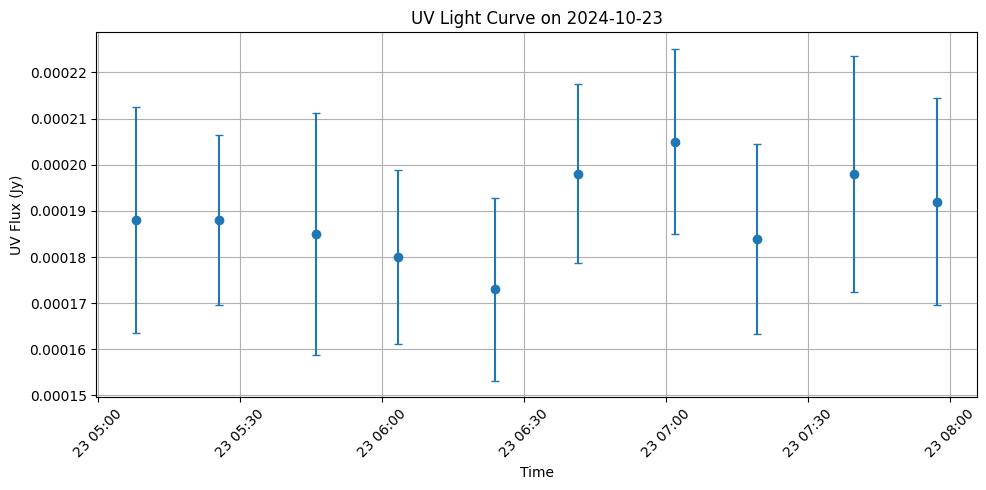

In [112]:
# Input from the observations
import pandas as pd

# Observations CSV file
file_path = '/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/FromNathan/XBand10-23_selected_columns.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(file_path)

# Convert 'Date' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Plot the UV light curve with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(df['datetime'], df['uv-Flux'], yerr=df['Im-Err'], fmt='o', capsize=3)
plt.xlabel('Time')
plt.ylabel('UV Flux (Jy)')
plt.title('UV Light Curve on 2024-10-23')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: Invalid shape (9, 256, 256) for image data

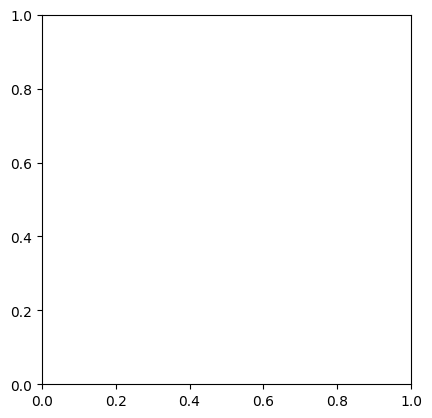

In [113]:
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
ims = fits.open('/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/temp_maps2/tref_gamma40_emis0.50/tempmap_rt_090.fits')[0].data

plt.imshow((ims[5,:]*u.Jy/u.arcsec**2).to_value('K', u.brightness_temperature(freq)), vmin=50, vmax=100)
plt.colorbar()

In [83]:
print(ims.shape)

(100, 256, 256)


## Average Brightness Temperature

This section calculates disk-averaged brightness temperature from models.

In [114]:
# calculate disk-averaged brightness temperature and save

from glob import glob

# full rotation model
lon = range(0, 360, 90)[:2]  # longitude   
filename_pattern = '/*_rt_90_???.fits'  # input image name pattern
outfile = 'Ganymed_integrated_model_90.fits'  # output file

freq = 343.5 * u.GHz  # observation frequency---
pxlscl_didy = 0.1 * u.mas  # pixel scale of simu images---
##pxlscl_dimo = 0.025 * u.mas

nemis = 3  # number of emissivity
nti = 7  # number of thermal inertia
nlon = 3

#
#simudir = glob('./temp_maps2/*')
simudir = subdirs

flux_all_didy = []
tb_all_didy = []
A_all_didy = []

flux_all_dimo = []
tb_all_dimo = []
A_all_dimo = []

flux_all = []
tb_all = []
A_all = []

gamma= []
for d in simudir:
    print('processing {}'.format(os.path.basename(d)))
    
    w1 = d.find('gamma')
    w2 = d.find('_', w1)
    gamma.append(float(d[w1 + len('gamma'):w2]))
    
    simufiles = glob(d + filename_pattern)
    nlon = len(simufiles)
    
    # didymos
    flux_d_didy = []  # fluxes of all files in one directory
    tb_d_didy = []  # brightness temperature of all files in one directory
    A_d_didy = []  # cross-section
    
    # dimorphos
    flux_d_dimo = []
    tb_d_dimo = []
    A_d_dimo = []

    # system
    flux_d = []
    tb_d = []
    A_d = []

    for f in simufiles:
        # didymos
        with fits.open(f) as f_:
            im = f_[0].data * u.Unit(f_[0].header['bunit'])
            nn = f_['refidx'].data
            loss = f_['loss'].data
        flux_d_didy.append((im.sum(axis=-1).sum(axis=-1) * pxlscl_didy**2).to('mJy'))
        A_d_didy.append((im[0, 0] > 0).astype(int).sum() * pxlscl_didy**2)
        tb_d_didy.append(flux_d_didy[-1].to('K', u.brightness_temperature(freq, A_d_didy[-1])))
        # print('{:.2f}, {:.2f}, {:.4f}'.format(flux[5, 4], tb[5, 4], A.to('arcsec2')))
        
        # dimorphos
        with fits.open(f.replace('didy', 'dimo')) as f_:
            im = f_[0].data * u.Unit(f_[0].header['bunit'])
            nn = f_['refidx'].data
            loss = f_['loss'].data
        flux_d_dimo.append((im.sum(axis=-1).sum(axis=-1) * pxlscl_dimo**2).to('mJy'))
        A_d_dimo.append((im[0, 0] > 0).astype(int).sum() * pxlscl_dimo**2)
        tb_d_dimo.append(flux_d_dimo[-1].to('K', u.brightness_temperature(freq, A_d_dimo[-1])))

        # both
        flux_d.append(flux_d_didy[-1] + flux_d_dimo[-1])
        A_d.append(A_d_didy[-1] + A_d_dimo[-1])
        tb_d.append(flux_d[-1].to('K', u.brightness_temperature(freq, A_d[-1])))
        
    flux_all.append(u.Quantity(flux_d))
    tb_all.append(u.Quantity(tb_d))
    A_all.append(u.Quantity(A_d))
    
    flux_all_didy.append(u.Quantity(flux_d_didy))
    tb_all_didy.append(u.Quantity(tb_d_didy))
    A_all_didy.append(u.Quantity(A_d_didy))
    
    flux_all_dimo.append(u.Quantity(flux_d_dimo))
    tb_all_dimo.append(u.Quantity(tb_d_dimo))
    A_all_dimo.append(u.Quantity(A_d_dimo))

# reorganize output
flux_all = u.Quantity(flux_all).reshape(nti, nemis, nlon, len(nn), len(loss))
tb_all = u.Quantity(tb_all).reshape(nti, nemis, nlon, len(nn), len(loss))
A_all = u.Quantity(A_all)

flux_all_didy = u.Quantity(flux_all_didy).reshape(nti, nemis, nlon, len(nn), len(loss))
tb_all_didy = u.Quantity(tb_all_didy).reshape(nti, nemis, nlon, len(nn), len(loss))
A_all_didy = u.Quantity(A_all_didy)

flux_all_dimo = u.Quantity(flux_all_dimo).reshape(nti, nemis, nlon, len(nn), len(loss))
tb_all_dimo = u.Quantity(tb_all_dimo).reshape(nti, nemis, nlon, len(nn), len(loss))
A_all_dimo = u.Quantity(A_all_dimo)

gamma = np.reshape(gamma, (nti, nemis))[:, 0]
emis = [0.75, 0.85, 0.95]

# order by increasing TI
st = gamma.argsort()
gamma = gamma[st]

flux_all = flux_all[st]
tb_all = tb_all[st]
A_all = A_all[st]

flux_all_didy = flux_all_didy[st]
tb_all_didy = tb_all_didy[st]
A_all_didy = A_all_didy[st]

flux_all_dimo = flux_all_dimo[st]
tb_all_dimo = tb_all_dimo[st]
A_all_dimo = A_all_dimo[st]


# save results
hdu0 = fits.PrimaryHDU(tb_all.value)
hdu0.header['bunit'] = str(tb_all.unit)
hdu0.header['ax1_name'] = 'loss', 'loss tangent'
hdu0.header['ax2_name'] = 'refidx', 'index of refraction'
hdu0.header['ax3_name'] = 'lon', 'longitude'
hdu0.header['ax4_name'] = 'emis', 'emissivity'
hdu0.header['ax5_name'] = 'ti', 'thermal inertia'

hdu1 = fits.ImageHDU(flux_all.value, name='flux')
hdu1.header['bunit'] = str(flux_all.unit)

hdu2 = fits.ImageHDU(loss, name='loss')
hdu3 = fits.ImageHDU(nn, name='refidx')
hdu4 = fits.ImageHDU(lon, name='lon')
hdu4.header['bunit'] = 'deg'
hdu5 = fits.ImageHDU(emis, name='emis')
hdu6 = fits.ImageHDU(gamma, name='ti')
hdu6.header['bunit'] = 'tiu'

hdu7 = fits.ImageHDU(A_all.value, name='xsec')
hdu7.header['bunit'] = str(A_all.unit)

hdu8 = fits.ImageHDU(tb_all_didy.value, name='tb_didy')
hdu8.header['bunit'] = str(tb_all_didy.unit)
hdu9 = fits.ImageHDU(flux_all_didy.value, name='flx_didy')
hdu9.header['bunit'] = str(flux_all_didy.unit)
hdu10 = fits.ImageHDU(A_all_didy.value, name='xsc_didy')
hdu10.header['bunit'] = str(A_all_didy.unit)

hdu11 = fits.ImageHDU(tb_all_dimo.value, name='tb_dimo')
hdu11.header['bunit'] = str(tb_all_dimo.unit)
hdu12 = fits.ImageHDU(flux_all_dimo.value, name='flx_dimo')
hdu12.header['bunit'] = str(flux_all_dimo.unit)
hdu13 = fits.ImageHDU(A_all_dimo.value, name='xsc_dimo')
hdu13.header['bunit'] = str(A_all_dimo.unit)

fits.HDUList([hdu0, hdu1, hdu2, hdu3, hdu4, hdu5, hdu6, hdu7, hdu8, hdu9, hdu10, hdu11, hdu12, hdu13]).writeto(outfile, overwrite=True)


processing tref_gamma40_emis0.50
processing tref_gamma10_emis0.70
processing tref_gamma20_emis0.50
processing tref_gamma320_emis0.70
processing tref_gamma160_emis0.50
processing tref_gamma640_emis0.70
processing tref_gamma640_emis0.90
processing tref_gamma320_emis0.90
processing tref_gamma80_emis0.50
processing tref_gamma10_emis0.90
processing tref_gamma40_emis0.90
processing tref_gamma160_emis0.90
processing tref_gamma20_emis0.90
processing tref_gamma80_emis0.70
processing tref_gamma320_emis0.50
processing tref_gamma20_emis0.70
processing tref_gamma80_emis0.90
processing tref_gamma160_emis0.70
processing tref_gamma640_emis0.50
processing tref_gamma40_emis0.70
processing tref_gamma10_emis0.50


In [115]:
#tb_model = fits.open('juno_integrated_model_data_refined.fits')
tb_model = fits.open('/Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/Ganymed_integrated_model_90.fits')
tb_model.info()
gamma = tb_model['ti'].data
loss = tb_model['loss'].data
refidx = tb_model['refidx'].data

Filename: /Users/zouxd/Documents/2-Projects/2024-YORPD/Ganymed/Ganymed_integrated_model_90.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (9, 11, 0, 3, 7)      
  1  FLUX          1 ImageHDU        12   (9, 11, 0, 3, 7)      
  2  LOSS          1 ImageHDU         7   (9,)   float64   
  3  REFIDX        1 ImageHDU         7   (11,)   float64   
  4  LON           1 ImageHDU         8   (2,)   int64   
  5  EMIS          1 ImageHDU         7   (3,)   float64   
  6  TI            1 ImageHDU         8   (7,)   float64   
  7  XSEC          1 ImageHDU         9   (0, 7)      
  8  TB_DIDY       1 ImageHDU        12   (9, 11, 0, 3, 7)      
  9  FLX_DIDY      1 ImageHDU        12   (9, 11, 0, 3, 7)      
 10  XSC_DIDY      1 ImageHDU         9   (0, 7)      
 11  TB_DIMO       1 ImageHDU        12   (9, 11, 0, 3, 7)      
 12  FLX_DIMO      1 ImageHDU        12   (9, 11, 0, 3, 7)      
 13  XSC_DIMO      1 ImageHDU         9   (

In [116]:
print(tb_model['flux'].data.min(), tb_model['flux'].data.max())

ValueError: zero-size array to reduction operation minimum which has no identity

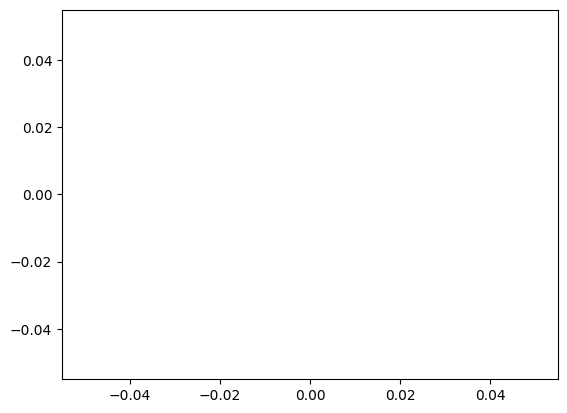

In [117]:
plt.plot((tb_model['flx_dimo'].data / tb_model['flux'].data).flatten(), 'o')

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

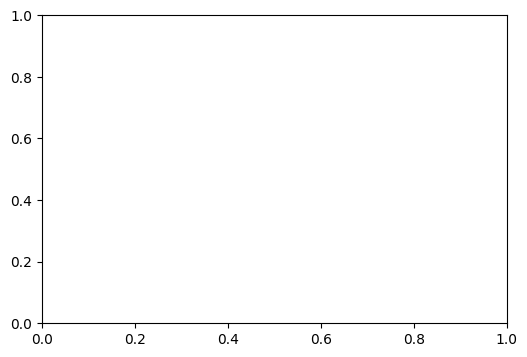

In [118]:
# lightcurve with fixed e, n, loss tan, but varying thermal inertia

e = 1  # emissivity index
n = 2  # n index
l = -2  # loss tangent index

f, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(len(gamma)):
    ax.plot(tb_model['lon'].data, tb_model['flux'].data[i, e, :, n, l], 'o')
plt.legend(gamma)
plt.text(0.8, 0.1, r'$\epsilon$ = {:.2f}'.format(tb_model['emis'].data[e]), transform=ax.transAxes)
plt.text(0.8, 0.06, 'n = {:.2f}'.format(tb_model['refidx'].data[n]), transform=ax.transAxes)
plt.text(0.8, 0.02, r'$\tan\Delta$ = {:.2f}'.format(tb_model['loss'].data[l]), transform=ax.transAxes)
jp.pplot(xlim=[-10, 100], xlabel='Longitude (deg)', ylabel='Flux ({})'.format(tb_model['flux'].header['bunit']))

In [119]:
l = 4
n = 5

for i in range(3):
    plt.plot(tb_model['ti'].data, tb_model['flux'].data[:, i, 0, n, l], 'o-')
ax = plt.gca()
plt.text(0.75, 0.08, 'n = {:.2f}'.format(tb_model['refidx'].data[n]), transform=ax.transAxes)
plt.text(0.75, 0.04, r'$\tan\Delta$ = {:.2e}'.format(tb_model['loss'].data[l]), transform=ax.transAxes)    
plt.legend(['emis 0.75', 'emis 0.85', 'emis 0.95'])
jp.pplot(xlabel='Thermal Inertia', ylabel='Flux (mJy)', xscl='log')

flux0 = 1.79
err0 = 0.18
plt.fill_between([10, 640], flux0 - err0, flux0 + err0, color='g', alpha=0.2)

IndexError: index 0 is out of bounds for axis 2 with size 0

In [120]:
l = 4
t = 2

for i in range(3):
    plt.plot(tb_model['refidx'].data, tb_model['flux'].data[t, i, 0, :, l], 'o-')
ax = plt.gca()
plt.text(0.05, 0.08, r'$\tan\Delta$ = {:.2e}'.format(tb_model['loss'].data[l]), transform=ax.transAxes)    
plt.text(0.05, 0.04, r'$\Gamma$ = {:.2f}'.format(tb_model['ti'].data[t]), transform=ax.transAxes)    
plt.legend(['emis 0.75', 'emis 0.85', 'emis 0.95'])
jp.pplot(xlabel='Index of Refraction', ylabel='Flux (mJy)')

flux0 = 1.79
err0 = 0.18
plt.fill_between([1, 2.5], flux0 - err0, flux0 + err0, color='g', alpha=0.2)

IndexError: index 0 is out of bounds for axis 2 with size 0

In [121]:
n = 4
t = 2

for i in range(3):
    plt.plot(tb_model['loss'].data, tb_model['flux'].data[t, i, 0, n, :], 'o-')
ax = plt.gca()
plt.text(0.8, 0.08, 'n = {:.2f}'.format(tb_model['refidx'].data[n]), transform=ax.transAxes)
plt.text(0.8, 0.04, r'$\Gamma$ = {:.2f}'.format(tb_model['ti'].data[t]), transform=ax.transAxes)    
plt.legend(['emis 0.75', 'emis 0.85', 'emis 0.95'])
jp.pplot(xlabel='Loss Tan', ylabel='Flux (mJy)', xscl='log')

flux0 = 1.79
err0 = 0.18
plt.fill_between([1e-4, 1], flux0 - err0, flux0 + err0, color='g', alpha=0.2)

IndexError: index 0 is out of bounds for axis 2 with size 0

In [122]:
# find the best fit models

# measured flux = 1.79 +/- 0.18 mJy.

nbest = 40

flux0 = 1.79 * u.mJy

flux_model = tb_model['flux'].data[:, :, 0, :, :].copy() * u.Unit(tb_model['flux'].header['bunit'])
shape = flux_model.shape

idxs = []
fit = []
res = []
for i in range(nbest):
    diff = abs(flux_model - flux0)
    idx = np.unravel_index(diff.argmin(), shape)
    idxs.append(idx)
    fit.append(flux_model[idx])
    res.append(diff.min())
    flux_model[idx] = 100 * u.mJy
    print('{:.5f}'.format(res[-1]), end=', ')
    print('{:.5f}'.format(fit[-1]), end=', ')
    print('{:.0f}'.format(tb_model['ti'].data[idx[0]]), end=', ')
    print('{:.2f}'.format(tb_model['emis'].data[idx[1]]), end=', ')
    print('{:.2f}'.format(tb_model['refidx'].data[idx[2]]), end=', ')
    print('{:.2e}'.format(tb_model['loss'].data[idx[3]]))
    

IndexError: index 0 is out of bounds for axis 2 with size 0

In [123]:
# search the parameter space with model within 1-sigma of measurements

# measured flux = 1.79 +/- 0.18 mJy.

from astropy.table import QTable

flux0 = 1.79 * u.mJy
err0 = 0.18 * u.mJy

flux_model = tb_model['flux'].data[:, :, 0, :, :].copy() * u.Unit(tb_model['flux'].header['bunit'])
shape = flux_model.shape

idxs = []
fit = []
res = []

ti = []
emis = []
nn = []
loss = []
while True:
    diff = abs(flux_model - flux0)
    idx = np.unravel_index(diff.argmin(), shape)
    idxs.append(idx)
    fit.append(flux_model[idx])
    res.append(diff.min())
    flux_model[idx] = 100 * u.mJy
    ti.append(tb_model['ti'].data[idx[0]])
    emis.append(tb_model['emis'].data[idx[1]])
    nn.append(tb_model['refidx'].data[idx[2]])
    loss.append(tb_model['loss'].data[idx[3]])

    if res[-1] >= err0:
        break

ti = u.Quantity(ti, tiu)
emis = u.Quantity(emis)
nn = u.Quantity(nn)
loss = u.Quantity(loss)
res = u.Quantity(res)
fit = u.Quantity(fit)
print(len(fit))

# save results
out = QTable([ti, emis, nn, loss, fit, res], names=['TI', 'emis', 'index', 'loss', 'fit', 'res'])
out.write('bestfit_parms.ecsv', overwrite=True)
out.write('bestfit_parms.csv', overwrite=True)

IndexError: index 0 is out of bounds for axis 2 with size 0

## Fit with Multiple Bands

344 GHz bands and 230 GHz bands.

* 344 GHz flux is measured to be 1.79 +/- 0.18 mJy
* 230 GHz flux is estimated to be 0.70 +/- 0.07 mJy
* 150 GHz flux 0.35 mJy
* 90 GHz flux 0.12 mJy

In [124]:
flux0 = [1.79, 0.75, 0.32, 0.08] * u.mJy
err0 = flux0 * 0.1  # [0.18, 0.07] * u.mJy
modelfiles = ['./Ganymed_integrated_model_344.fits',
              './Ganymed_integrated_model_230.fits',
              './Ganymed_integrated_model_150.fits',
              './Ganymed_integrated_model_90.fits',
             ]

flux_model = []
for f in modelfiles:
    f_ = fits.open(f)
    flux_model.append(f_['flux'].data[:, :, 0, :, :] * u.Unit(f_['flux'].header['bunit']))
flux_model = np.stack(flux_model)
flux_model = np.moveaxis(flux_model, 0, -1)
#flux_model.shape

with fits.open(modelfiles[0]) as f_:
    gamma = f_['ti'].data
    loss = f_['loss'].data
    refidx = f_['refidx'].data
    emis = f_['emis'].data

    
diff = (((flux_model - flux0) / err0)**2).sum(axis=-1)
rms = np.sqrt(((flux_model - flux0)**2).mean(axis=-1))
shape = diff.shape

idxs = []
chisq = []
res = []

ti = []
em = []
nn = []
ll = []
while True:

    idx = np.unravel_index(diff.argmin(), shape)
    idxs.append(idx)
    chisq.append(diff.min())
    res.append(rms[idx])
    diff[idx] = 1e5
    
    ti.append(gamma[idx[0]])
    em.append(emis[idx[1]])
    nn.append(refidx[idx[2]])
    ll.append(loss[idx[3]])
    
    if chisq[-1] >= chisq[0] * 2:
        break

ti = u.Quantity(ti, tiu)
em = u.Quantity(em)
nn = u.Quantity(nn)
ll = u.Quantity(ll)
chisq = u.Quantity(chisq)
res = u.Quantity(res)
print(len(res))

# save results
out = QTable([ti, em, nn, ll, chisq, res], names=['TI', 'emis', 'index', 'loss', 'chisq', 'rms'])
out.write('bestfit_parms_4bands.ecsv', overwrite=True)
out.write('bestfit_parms_4bands.csv', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: './Ganymed_integrated_model_344.fits'

AttributeError: 'list' object has no attribute 'value'

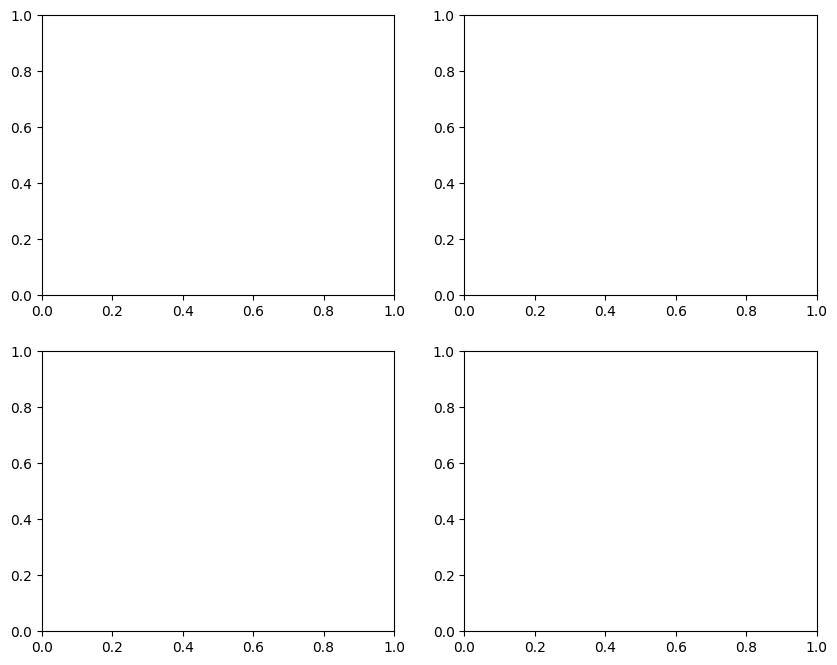

In [125]:
f, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].hist(np.log10(ti.value), bins=15, weights=1/chisq)
ax[0, 1].hist(em.value, bins=10, weights=1/chisq)
ax[1, 0].hist(nn.value, bins=15, weights=1/chisq)
ax[1, 1].hist(np.log10(ll.value), bins=15, weights=1/chisq)
#for a in ax.flatten():
#    a.axes.yaxis.set_ticklabels([])
jp.pplot(ax[0, 0], xlabel='log10(TI)')
jp.pplot(ax[0, 1], xlabel='Emissivity')
jp.pplot(ax[1, 0], xlabel='Index of Refraction')
jp.pplot(ax[1, 1], xlabel='log10(loss tan)')

In [425]:
flux_model.shape

(7, 3, 11, 9, 4)

In [450]:
refidx[n]

2.0503

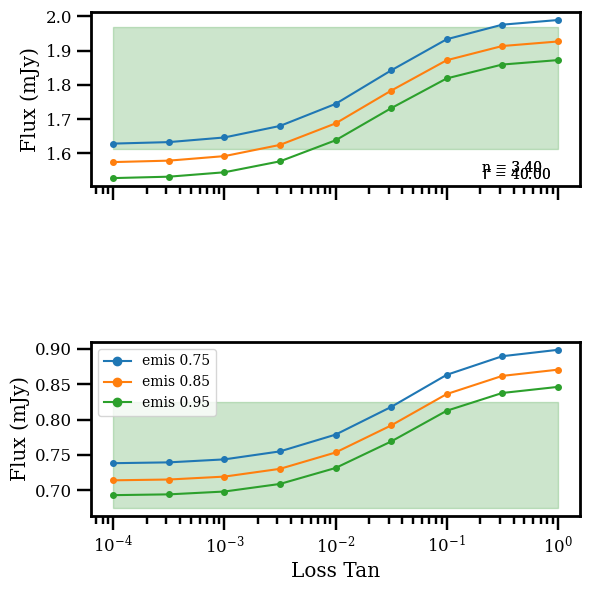

In [453]:

flux0 = [1.79, 0.75, 0.32, 0.08] * u.mJy
err0 = flux0 * 0.1  # [0.18, 0.07] * u.mJy
modelfiles = ['./didy_integrated_model_344.fits',
              './didy_integrated_model_230.fits',
              './didy_integrated_model_150.fits',
              './didy_integrated_model_90.fits',
             ]

flux_model = []
for f in modelfiles:
    f_ = fits.open(f)
    flux_model.append(f_['flux'].data[:, :, 0, :, :] * u.Unit(f_['flux'].header['bunit']))
flux_model = np.stack(flux_model)
flux_model = np.moveaxis(flux_model, 0, -1)
#flux_model.shape

with fits.open(modelfiles[0]) as f_:
    gamma = f_['ti'].data
    loss = f_['loss'].data
    refidx = f_['refidx'].data
    emis = f_['emis'].data


n = 8
t = 2

f, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

for i in range(3):
    ax[0].plot(loss, flux_model[t, i, n, :, 0], 'o-')
plt.text(0.8, 0.08, 'n = {:.2f}'.format(tb_model['refidx'].data[n]), transform=ax[0].transAxes)
plt.text(0.8, 0.04, r'$\Gamma$ = {:.2f}'.format(tb_model['ti'].data[t]), transform=ax[0].transAxes)    
plt.legend(['emis 0.75', 'emis 0.85', 'emis 0.95'])
jp.pplot(ax[0], ylabel='Flux (mJy)', xscl='log')
ax[0].fill_between([1e-4, 1], (flux0[0] - err0[0]).value, (flux0[0] + err0[0]).value, color='g', alpha=0.2)

for i in range(3):
    ax[1].plot(loss, flux_model[t, i, n, :, 1], 'o-')
plt.text(0.8, 0.08, 'n = {:.2f}'.format(tb_model['refidx'].data[n]), transform=ax[0].transAxes)
plt.text(0.8, 0.04, r'$\Gamma$ = {:.2f}'.format(tb_model['ti'].data[t]), transform=ax[0].transAxes)    
plt.legend(['emis 0.75', 'emis 0.85', 'emis 0.95'])
jp.pplot(ax[1], xlabel='Loss Tan', ylabel='Flux (mJy)', xscl='log')
ax[1].fill_between([1e-4, 1], (flux0[1] - err0[1]).value, (flux0[1] + err0[1]).value, color='g', alpha=0.2)

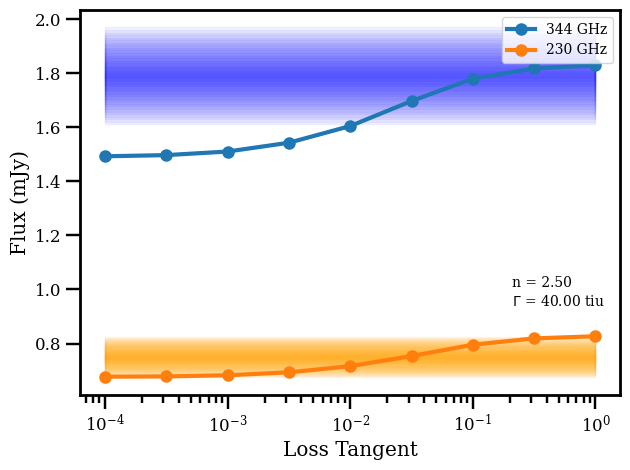

In [482]:

flux0 = [1.79, 0.75, 0.32, 0.08] * u.mJy
err0 = flux0 * 0.1  # [0.18, 0.07] * u.mJy
modelfiles = ['./didy_integrated_model_344.fits',
              './didy_integrated_model_230.fits',
              './didy_integrated_model_150.fits',
              './didy_integrated_model_90.fits',
             ]

flux_model = []
for f in modelfiles:
    f_ = fits.open(f)
    flux_model.append(f_['flux'].data[:, :, 0, :, :] * u.Unit(f_['flux'].header['bunit']))
flux_model = np.stack(flux_model)
flux_model = np.moveaxis(flux_model, 0, -1)
#flux_model.shape

with fits.open(modelfiles[0]) as f_:
    gamma = f_['ti'].data
    loss = f_['loss'].data
    refidx = f_['refidx'].data
    emis = f_['emis'].data


n = 9
t = 2


plt.plot(loss, flux_model[t, 2, n, :, 0], 'o-', ms=8, lw=3)
plt.plot(loss, flux_model[t, 2, n, :, 1], 'o-', ms=8, lw=3)
ax = plt.gca()
plt.text(0.8, 0.28, 'n = {:.2f}'.format(nn[n]), transform=ax.transAxes)
plt.text(0.8, 0.23, r'$\Gamma$ = {:.2f} tiu'.format(gamma[t]), transform=ax.transAxes)    
plt.legend(['344 GHz', '230 GHz'])
jp.pplot(ax, ylabel='Flux (mJy)', xscl='log', skipline=True, xlabel='Loss Tangent')

for x in np.linspace(0, err0[0], 20):
    ax.fill_between([1e-4, 1], (flux0[0] - x).value, (flux0[0] + x).value, color='b', alpha=0.05)
for x in np.linspace(0, err0[1], 20):
    ax.fill_between([1e-4, 1], (flux0[1] - x).value, (flux0[1] + x).value, color='orange', alpha=0.08)


In [468]:
ti

<Quantity [ 10.,  10.,  20.,  40.,  20.,  20.,  10.,  80.,  10.,  40.,
            10.,  10.,  80., 160.,  40.,  20.,  40., 320.,  20.,  40.,
            20., 160., 640.,  10.,  10., 320.,  80., 640.,  20., 320.,
           640.,  80., 160., 640.,  80.,  10., 160.,  20., 640., 160.,
            40.,  40.,  80., 320.,  80., 320., 320., 160.,  40.,  20.,
            80.,  80., 160.,  40.,  40.,  80., 640., 160., 160., 640.,
            20.,  20.,  10., 640., 640.,  40.,  40.,  80.,  40.,  80.,
           320., 160.,  80., 160.,  40., 320.,  20., 640.,  80., 320.,
            40., 160., 320.,  80.,  20.,  80., 640.,  10.,  10., 160.,
            40., 160.,  20.,  10., 320., 320.,  10.,  10., 640., 640.,
           320.,  80.,  80.,  40.,  40., 320.,  80., 160.,  40., 160.,
            20.,  20., 640., 640., 640., 640., 160., 640., 160.,  40.,
            80.,  10.,  20.,  20., 640., 160.,  20., 320.,  40.,  80.,
            40.,  10.,  10.,  40.,  40., 320.,  40.,  20.,  80.,  80.,
      

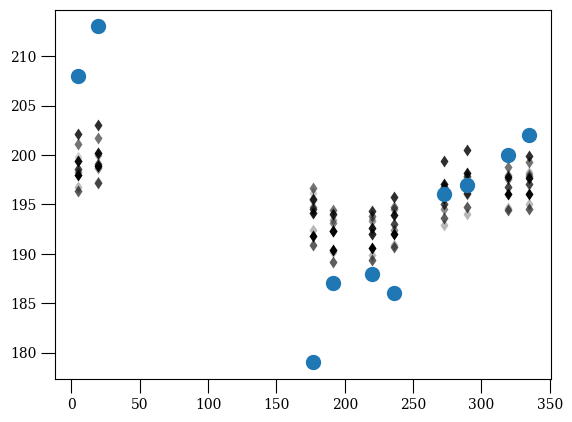

In [607]:
st = lon.argsort()
for i in range(n):
    plt.plot(lon[st], tb_model[index[i]][st], 'kd', alpha=(11-i)/11, mec='none')
plt.plot(lon, data['Tb_med'], 'o', ms=10)

In [ ]:
# fit all photometry points in **flux**

from astropy.io import ascii
from astropy.table import Table, hstack

weighted = True
n = 40   # fit the first n best solutions

# load data
obs_data = ascii.read('hunter_etal_table.ecsv')
obs_geom = ascii.read('data/juno_data_geom.csv')
data = hstack([obs_data, obs_geom])

# scale flux by a factor to test the sensitivity to calibration uncertainty
data['flux'] *= 1.   # scale up by 10%


# load model
with fits.open('juno_integrated_model_data_refined.fits') as f_:
    flux_model = f_[1].data * u.Unit(f_[1].header['bunit'])
    loss = f_['loss'].data
    nn = f_['refidx'].data
    lon = f_['lon'].data
    emis = f_['emis'].data
    ti = f_['ti'].data
    
flux_model = np.moveaxis(flux_model, 2, -1)  # move image axis to the last
if weighted:
    chisq = ((flux_model - data['flux'])**2/data['flux_err']**2).sum(axis=-1)
else:
    chisq = ((flux_model - data['flux'])**2).sum(axis=-1)
rms_fit = []
chi_sq = []
ti_fit = []
emis_fit = []
nn_fit = []
loss_fit = []
index = []
for i in range(n):
    best = np.unravel_index(chisq.argmin(), chisq.shape)
    chi_sq.append(chisq[best])
    rms_fit.append(np.sqrt(((flux_model[best] - data['flux'])**2).sum()/len(data)))
    ti_fit.append(ti[best[0]])
    emis_fit.append(emis[best[1]])
    nn_fit.append(nn[best[2]])
    loss_fit.append(loss[best[3]])
    index.append(best)
    if weighted:
        chisq[best] = 1e5
    else:
        chisq[best] = 1e5 * u.mJy**2
# save best fit parameters
results = Table([u.Quantity(chi_sq)/len(data), rms_fit, u.Quantity(rms_fit)/data['flux'].mean(), ti_fit, emis_fit, nn_fit, loss_fit], names=['red.chisq', 'rms', 'rel.rms', 'ti', 'emis', 'n', 'loss'])
#results['chisq'].format='.2f'
results['red.chisq'].format='.2f'
results['rms'].format='.2f'
results['rel.rms'].format='.4f'
results.write('model_{}fitting_results_flux_refined_5%up.ecsv'.format('weighted_' if weighted else ''), overwrite=True)

# save best fit index
np.save('model_{}fitting_index_flux_refined_5%up.npy'.format('weighted_' if weighted else ''), index)

results.pprint(max_lines=-1, max_width=-1)

red.chisq rms  rel.rms   ti  emis   n        loss   
          mJy                                       
--------- ---- ------- ----- ---- ------ -----------
     2.82 2.73  0.0139  20.0  0.7 1.6006  0.31622776
     2.95 2.81  0.0143  20.0  0.7 1.4507         0.1
     3.02 2.73  0.0139  20.0  0.7 1.7505         1.0
     3.07 2.78  0.0142  40.0  0.7 1.7505  0.31622776
     3.13 2.78  0.0141  40.0  0.8 1.6006         1.0
     3.15 2.91  0.0148  40.0  0.7 1.6006         0.1
     3.23 2.82  0.0143  20.0  1.0 1.1509         1.0
     3.23 2.90  0.0148  40.0  0.9 1.3008  0.31622776
     3.27 2.95  0.0150  20.0  0.9 1.1509  0.31622776
     3.37 2.91  0.0148  40.0  1.0 1.1509  0.31622776
     3.45 3.07  0.0157  20.0  1.0  1.001  0.31622776
     3.59 3.04  0.0155  80.0  0.8 1.6006         1.0
     3.62 3.17  0.0161  40.0  0.9 1.1509         0.1
     3.65 3.01  0.0153  20.0  0.9 1.3008         1.0
     3.89 3.27  0.0166  80.0  0.7 1.7505  0.31622776
     3.94 3.04  0.0155  20.0  0.8 1.4507  0.31

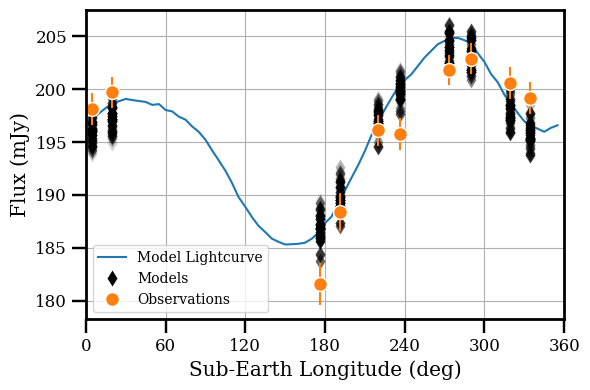

In [11]:
# plot results
from astropy.table import hstack

weighted = True

# load data
obs_data = ascii.read('hunter_etal_table.ecsv')
obs_geom = ascii.read('data/juno_data_geom.csv')
data = hstack([obs_data, obs_geom])

# load dense lightcurve with juno shape model
with fits.open('juno_integrated_model_refined.fits') as f_:
    lc_simu = f_['flux'].data * u.Unit(f_['flux'].header['bunit'])
    lc_lon = f_['lon'].data
lc_simu = np.moveaxis(lc_simu, 2, -1)

# load model corresponding to actual data points
with fits.open('juno_integrated_model_data_refined.fits') as f_:
    model = f_['flux'].data * u.Unit(f_['flux'].header['bunit'])
    model_lon = f_['lon'].data
model = np.moveaxis(model, 2, -1)

# load lightcurve with ellipsoidal model
with fits.open('juno_ellips_integrated_model.fits') as f_:
    lc_ellip_simu = f_['flux'].data * u.Unit(f_['flux'].header['bunit'])
    lc_ellip_lon = f_['lon'].data
lc_ellip_simu = np.moveaxis(lc_ellip_simu, 2, -1)

# load best-fit results for actual shape
index = np.load('model_{}fitting_index_flux_refined.npy'.format('weighted_' if weighted else ''))

# load best-fit from ellipse shape
index_ellips = np.load('model_ellips_fitting_index_flux.npy')

st = model_lon.argsort()  # sort in longitude
nsol = index.shape[0]  # number of solutions

plt.figure(figsize=(6, 4))
plt.plot(lc_lon, lc_simu[tuple(index[0])], label='Model Lightcurve')  # simulated lightcurve
#plt.plot(lc_ellip_lon, lc_ellip_simu[tuple(index_ellips[0])], '--')  # simulated lightcurve with ellipsoidal shape
for i in range(nsol)[::-1][:-1]:
    plt.plot(model_lon[st], model[tuple(index[i])][st], 'kd', alpha=(nsol+1-i)/(nsol+1), mec='none', ms=8, label='_nolegend_')
plt.plot(model_lon[st], model[tuple(index[i])][st], 'kd', alpha=(nsol+1-i)/(nsol+1), mec='none', ms=8, label='Models')
plt.errorbar(data['SOLon'], data['flux'], data['flux_err'], marker='o', linestyle='none', ms=10, mec='w', label='Observations')#, color='k')  # data
jp.pplot(xlabel='Sub-Earth Longitude (deg)', ylabel='Flux (mJy)', xlim=[0, 360], xticks=np.linspace(0, 360, 7), skipline=True)
#plt.legend(['Lightcurve', 'Ellipsoidal Lightcurve', 'Observations'], loc='lower left')
plt.legend(loc='lower left')
plt.grid()

#plt.savefig('model_{}fitting_results_flux.png'.format('weighted_' if weighted else ''))
#plt.savefig('../../Proposals/2023-04-ALMA_NEOs/juno_model.png')
#plt.savefig('../../Proposals/2023-04-ALMA_NEOs/juno_model.pdf')

{'ti': 49.414898408103454, 'emis': 0.8195701163017739, 'n': 1.4122818348445938, 'loss': 0.4035096712689468}


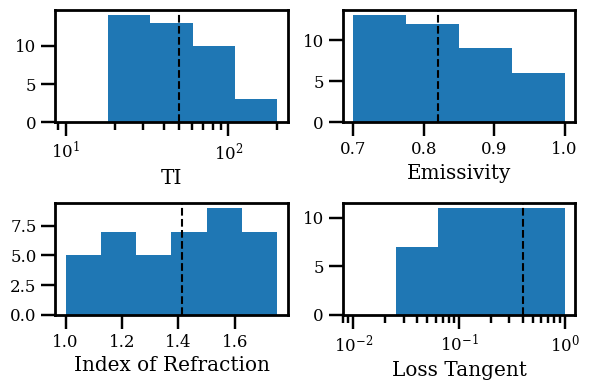

In [325]:
# parameter distribution

pars = ascii.read('model_weighted_fitting_results_flux_refined.ecsv')

par_avg = {}
for k in ['ti', 'emis', 'n', 'loss']:
    par_avg[k] = (pars[k] / pars['red.chisq']).sum() / (1 / pars['red.chisq']).sum()

f, ax = plt.subplots(2, 2, figsize=(6, 4))
ax[0, 0].hist(pars['ti'], bins=np.logspace(1, 2.3, 6))
ax[0, 0].axvline(par_avg['ti'], color='k', ls='--')
jp.pplot(ax[0, 0], xscl='log', xlabel='TI')
ax[0, 1].hist(pars['emis'], bins=4)
ax[0, 1].axvline(par_avg['emis'], color='k', ls='--')
jp.pplot(ax[0, 1], xlabel='Emissivity')
ax[1, 0].hist(pars['n'], bins=6)
ax[1, 0].axvline(par_avg['n'], color='k', ls='--')
jp.pplot(ax[1, 0], xlabel='Index of Refraction')
ax[1, 1].hist(pars['loss'], bins=np.logspace(-2, 0, 6))
ax[1, 1].axvline(par_avg['loss'], color='k', ls='--')
jp.pplot(ax[1, 1], xscl='log', xlabel='Loss Tangent')
plt.savefig('model_weighted_fitting_pars.png')

print(par_avg)

{'ti': 49.414898408103454, 'emis': 0.8195701163017739, 'n': 1.4122818348445938, 'loss': 0.4035096712689468}


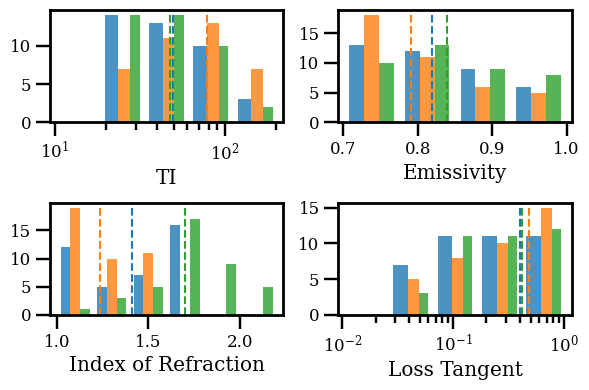

In [33]:
# parameter distribution

pars = ascii.read('model_weighted_fitting_results_flux_refined.ecsv')
pars_up = ascii.read('model_weighted_fitting_results_flux_refined_5%up.ecsv')
pars_down = ascii.read('model_weighted_fitting_results_flux_refined_5%down.ecsv')

par_avg = {}
par_up_avg = {}
par_down_avg = {}
for k in ['ti', 'emis', 'n', 'loss']:
    par_avg[k] = (pars[k] / pars['red.chisq']).sum() / (1 / pars['red.chisq']).sum()
    par_up_avg[k] = (pars_up[k] / pars_up['red.chisq']).sum() / (1 / pars_up['red.chisq']).sum()
    par_down_avg[k] = (pars_down[k] / pars_down['red.chisq']).sum() / (1 / pars_down['red.chisq']).sum()

f, ax = plt.subplots(2, 2, figsize=(6, 4))
ax[0, 0].hist([pars['ti'], pars_up['ti'], pars_down['ti']], bins=np.logspace(1, 2.3, 6), label=['orig', '10% up', '5% down'], alpha=0.8)
ax[0, 0].axvline(par_avg['ti'], color='tab:blue', ls='--')
ax[0, 0].axvline(par_up_avg['ti'], color='tab:orange', ls='--')
ax[0, 0].axvline(par_down_avg['ti'], color='tab:green', ls='--')
#ax[0, 0].legend(loc='lower left')
jp.pplot(ax[0, 0], xscl='log', xlabel='TI')

ax[0, 1].hist([pars['emis'], pars_up['emis'], pars_down['emis']], bins=4, alpha=0.8)
ax[0, 1].axvline(par_avg['emis'], color='tab:blue', ls='--')
ax[0, 1].axvline(par_up_avg['emis'], color='tab:orange', ls='--')
ax[0, 1].axvline(par_down_avg['emis'], color='tab:green', ls='--')
jp.pplot(ax[0, 1], xlabel='Emissivity')

ax[1, 0].hist([pars['n'], pars_up['n'], pars_down['n']], bins=6, alpha=0.8)
ax[1, 0].axvline(par_avg['n'], color='tab:blue', ls='--')
ax[1, 0].axvline(par_up_avg['n'], color='tab:orange', ls='--')
ax[1, 0].axvline(par_down_avg['n'], color='tab:green', ls='--')
jp.pplot(ax[1, 0], xlabel='Index of Refraction')

ax[1, 1].hist([pars['loss'], pars_up['loss'], pars_down['loss']], bins=np.logspace(-2, 0, 6), alpha=0.8)
ax[1, 1].axvline(par_avg['loss'], color='tab:blue', ls='--')
ax[1, 1].axvline(par_up_avg['loss'], color='tab:orange', ls='--')
ax[1, 1].axvline(par_down_avg['loss'], color='tab:green', ls='--')
jp.pplot(ax[1, 1], xscl='log', xlabel='Loss Tangent')
#plt.savefig('model_weighted_fitting_pars.png')

print(par_avg)

In [286]:
# fix emissivity = 0.9 and fit all photometry points in **flux**

from astropy.io import ascii
from astropy.table import Table, hstack

weighted = True
n = 9   # fit the first n best solutions
emis_fixed = 0.9

# load data
obs_data = ascii.read('hunter_etal_table.ecsv')
obs_geom = ascii.read('data/juno_data_geom.csv')
data = hstack([obs_data, obs_geom])

# load model
with fits.open('juno_integrated_model_data_refined.fits') as f_:
    flux_model = f_[1].data * u.Unit(f_[1].header['bunit'])
    loss = f_['loss'].data
    nn = f_['refidx'].data
    lon = f_['lon'].data
    emis = f_['emis'].data
    ti = f_['ti'].data

flux_model = np.moveaxis(flux_model, 2, -1)  # move image axis to the last
emi_index = np.where(emis == emis_fixed)[0]
flux_model = flux_model[:, emis==emis_fixed]

if weighted:
    chisq = ((flux_model - data['flux'])**2/data['flux_err']**2).sum(axis=-1)
else:
    chisq = ((flux_model - data['flux'])**2).sum(axis=-1)
rms_fit = []
chi_sq = []
ti_fit = []
nn_fit = []
loss_fit = []
index = []
for i in range(n):
    best = np.unravel_index(chisq.argmin(), chisq.shape)
    chi_sq.append(chisq[best])
    rms_fit.append(np.sqrt(((flux_model[best] - data['flux'])**2).sum()/len(data)))
    ti_fit.append(ti[best[0]])
    nn_fit.append(nn[best[2]])
    loss_fit.append(loss[best[3]])
    if weighted:
        chisq[best] = 1e5
    else:
        chisq[best] = 1e5 * u.mJy**2
    best = list(best)
    best[1] = emi_index[0]  # set to index of the fixed `emis_fixed`
    index.append(best)

# save best fit parameters
results = Table([u.Quantity(chi_sq)/len(data), rms_fit, u.Quantity(rms_fit)/data['flux'].mean(), ti_fit, nn_fit, loss_fit], names=['red.chisq', 'rms', 'rel.rms', 'ti', 'n', 'loss'])
#results['chisq'].format='.2f'
results['red.chisq'].format='.2f'
results['rms'].format='.2f'
results['rel.rms'].format='.4f'
results.write('model_{}fitting_results_flux_refined_emis{:.1f}.ecsv'.format('weighted_' if weighted else '', emis_fixed), overwrite=True)

# save best fit index
np.save('model_{}fitting_index_flux_refined_emis{:.1f}.npy'.format('weighted_' if weighted else '', emis_fixed), index)

results.pprint(max_lines=-1, max_width=-1)

red.chisq rms  rel.rms  ti    n        loss   
          mJy                                 
--------- ---- ------- ---- ------ -----------
     3.23 2.90  0.0148 40.0 1.3008  0.31622776
     3.27 2.95  0.0150 20.0 1.1509  0.31622776
     3.62 3.17  0.0161 40.0 1.1509         0.1
     3.65 3.01  0.0153 20.0 1.3008         1.0
     3.95 3.22  0.0164 80.0 1.3008         0.1
     4.11 3.37  0.0172 20.0  1.001 0.031622775
     4.33 3.18  0.0162 40.0 1.4507         1.0
     4.45 3.61  0.0184 20.0  1.001         0.1
     4.62 3.33  0.0169 80.0 1.4507         1.0


Actually, the solutions for emissivity = 0.9 are all included in the previous solution with free emissivity, and are just the special cases in the list of previous solutions.  Therefore, the result is that the fit puts no constraints to emissivity.  In other words, the list of 40 solutions from previous results shows that no matter what emissivity is assumed, the constraints to all other parameters (TI, n, and loss tangent) are the same.  Emissivity of 0.7 is statistically weakly preferred because it occupies the several solutions of the smallest $\chi^2$'s.

## Effective Emissivity

The effective emissivity is calculated here as the ratio of the measured flux to the modeled flux from the surface.

7/5/2023:

The concept of "effective emissivity" calculated here is confusing.  The traditional way of calculating the "mm-wavelength effective emissivity" is to use a spherical shape of the same effective size and a non-rotating body, i.e., STM, insolated and viewed at the same geometry to calculate the expected flux (e.g., [Redman et al. 1998](https://iopscience.iop.org/article/10.1086/300495)).  But the intention here is to study the rotational variations in thermal and dielectric properties after taking into account the effect of shape.  Therefore, we cannot use the traditional concept of effective emissivity here.

The go-around is to not invoke effective emissivity, but rather just use deviation from the best-fit model in the total flux.  The notations in the following cells are not changed.  But the interpretation should not be effective emissivity.

Below two cells are the original and obsolete now.

In [13]:
from glob import glob
from astropy.modeling.models import BlackBody
import astropy.units as u
from astropy.io import ascii

obsfile = 'hunter_etal_table.ecsv'
geofile = 'data/juno_data_geom.csv'
simufile = glob('./temp_maps/tref_gamma40_emis0.8/tempmap_simu??.fits')

freq = 233 * u.GHz
pxlscl = 2 * u.mas  # pixel scale of simu images

# calculate model flux from surface temperature models
temp = u.Quantity([fits.open(f)[0].data[0] for f in simufile], u.K)
flux_model = (BlackBody(temp)(freq).to('Jy/arcsec2').sum(axis=1).sum(axis=1) * pxlscl**2).to('mJy')

# load observations
obs = ascii.read(obsfile)
geom = ascii.read(geofile)

# emissivity
eff_emis = (obs['flux'] / flux_model).decompose()
eff_emis_err = (obs['flux_err'] / flux_model).decompose()

/Users/jyli/.env/work/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


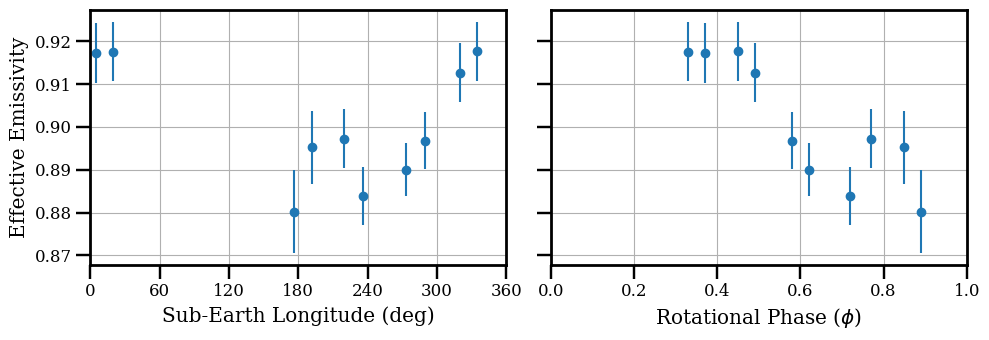

In [14]:
# plot effective emissivity

f, ax = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

ax[0].errorbar(geom['SOLon'], eff_emis, eff_emis_err, fmt='o')
jp.pplot(ax[0], xlabel='Sub-Earth Longitude (deg)', ylabel='Effective Emissivity', skipline=True, xticks=np.linspace(0, 360, 7), xlim=[0, 360])
ax[0].grid()

ax[1].errorbar(obs['phi1'], eff_emis, eff_emis_err, fmt='o')
jp.pplot(ax[1], xlabel=r'Rotational Phase ($\phi$)', skipline=True, xlim=[0, 1])
ax[1].grid()


# Make a similar plot as Ceres paper Fig. 4

In [801]:
# load model
with fits.open('juno_integrated_model_data_refined.fits') as f_:
    tb_model = f_[0].data * u.Unit(f_[0].header['bunit'])
    flux_model = f_[1].data * u.Unit(f_[1].header['bunit'])
    loss = f_['loss'].data
    nn = f_['refidx'].data
    lon = f_['lon'].data
    emis = f_['emis'].data
    ti = f_['ti'].data

# load data
obs_data = ascii.read('hunter_etal_table.ecsv')
obs_geom = ascii.read('juno_data_geom.csv')
data = hstack([obs_data, obs_geom])


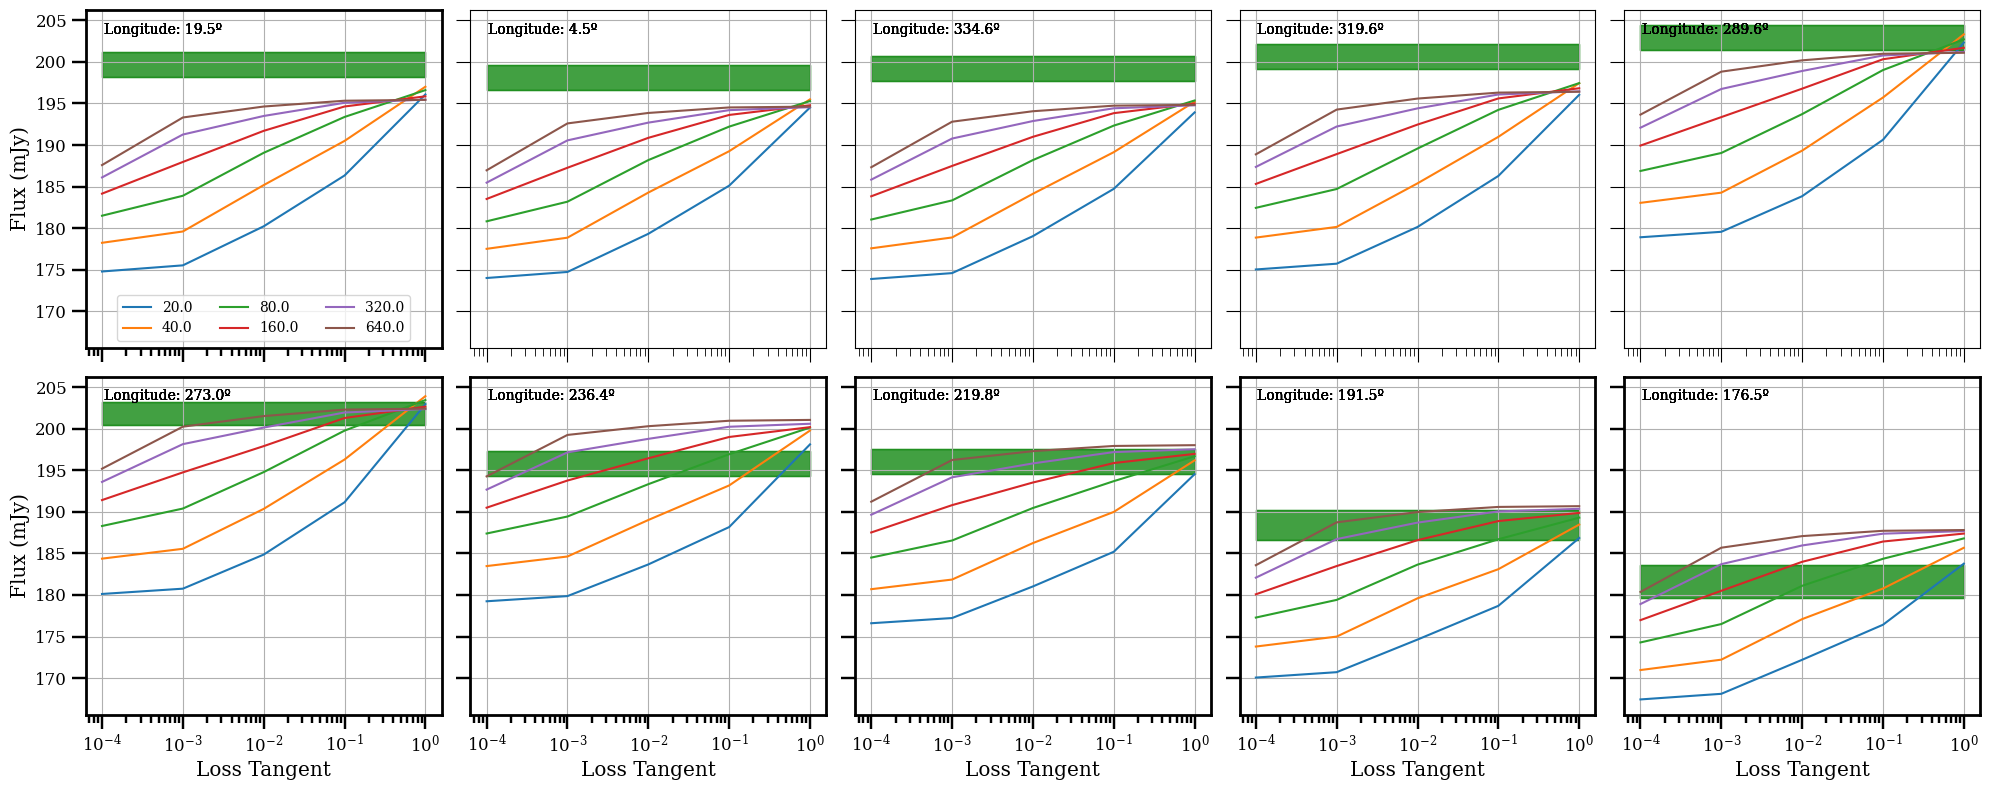

In [813]:

f, ax = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
ax1d = ax.flatten()

for j in range(10):
    for i in range(6):
        ax1d[j].plot(loss, flux_model[i, 1, j, 2])
        flux = data['flux'][j].to_value('mJy')
        flux_l = flux - data['flux_err'][j].to_value('mJy')
        flux_u = flux + data['flux_err'][j].to_value('mJy')
        ax1d[j].fill_between([1e-4, 1], flux_l, flux_u, color='g', alpha=0.2, label='_nolegend_')
        #ax1d[j].axhline(flux, ls=':', color='k', label='_nolegend_')
        ax1d[j].text(0.05, 0.93, 'Longitude: {:.1f}º'.format(data['SOLon'][j]), transform=ax1d[j].transAxes)
ax[0, 0].legend(ti, ncol=3, loc='lower center')

jp.pplot(ax[0, 0], xscl='log', ylabel='Flux (mJy)')
jp.pplot(ax[1, 0], xlabel='Loss Tangent', ylabel='Flux (mJy)')
for i in range(1, 5, 1):
    jp.pplot(ax[1, i], xlabel='Loss Tangent')
for a in ax1d:
    a.grid()


## Geometry of historical observations

In [59]:
import spiceypy as spice

utcs = ['1954-01-' + x for x in ['10', '11', '17', '28']] + ['1958-01-14', '1961-10-17'] + \
       ['1980-' + x for x in ['02-07', '02-08', '02-09', '03-12', '03-13']] + \
       ['2000-08-05', '1996-10-15']


jp.load_generic_kernels()
spice.furnsh('../spice/juno_19500101-20501231_20220602.bsp')
spice.furnsh('../shape/juno.tpc')

geom = jp.subcoord(utcs, 'juno')

geom

Time,rh,Range,Phase,RA,Dec,SOLat,SOLon,SSLat,SSLon,PolePA,PoleInc,SunPA,SunInc
,AU,AU,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1954-01-10,2.3189,1.4686,15.39,144.36,0.18,-36.77,218.72,-50.78,209.80,328.10,-36.77,126.43,74.61
1954-01-11,2.3216,1.4638,15.00,144.23,0.25,-36.90,100.18,-50.63,91.74,328.16,-36.90,127.07,75.00
1954-01-17,2.3380,1.4393,12.54,143.33,0.75,-37.80,108.89,-49.68,103.32,328.54,-37.80,131.73,77.46
1954-01-28,2.3683,1.4161,7.88,141.23,2.06,-40.00,244.74,-47.88,244.42,329.39,-40.00,147.81,82.12
1958-01-14,2.0411,1.2567,21.35,70.05,0.76,-35.30,164.46,-53.25,180.88,34.28,-35.30,241.97,68.65
1961-10-17,2.1643,1.2736,15.46,351.84,-9.21,26.02,9.03,10.91,12.51,46.39,26.02,239.30,74.54
1980-02-07,2.2324,1.3471,14.38,106.70,5.62,-52.57,275.00,-55.74,299.09,2.77,-52.57,250.47,75.62
1980-02-08,2.2348,1.3550,14.71,106.60,5.79,-52.73,156.47,-55.64,181.26,2.90,-52.73,251.64,75.29
